### Importación de Librerías necesarias

In [24]:
import os
import zipfile
import requests
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Masking, Dropout
from tensorflow.keras.callbacks import EarlyStopping


### 1. Importación de datos desde Github (Datos tomados con Edge Impulse)

Descarga y descompresión de un archivo .zip desde el repositorio de GitHub. El archivo contiene los datos recolectados mediante Edge Impulse, que serán utilizados posteriormente para entrenar modelos de clasificación de series de tiempo. Se maneja la operación con un bloque try-except para capturar y reportar posibles errores en la descarga o extracción.

In [25]:
# URL del archivo ZIP en GitHub que contiene los datos exportados desde Edge Impulse
GITHUB_URL = "https://github.com/DCajiao/Time-Series-Classification-with-Recurrent-Networks/raw/main/data/zip/dcajiao-project-1-export.zip"

# Nombre local con el que se guardará el archivo ZIP una vez descargado
zip_path = "dcajiao-project-1-export.zip"

try:
    # Realiza una petición HTTP para descargar el contenido del archivo desde GitHub
    response = requests.get(GITHUB_URL)

    # Guarda el contenido descargado en un archivo ZIP localmente
    with open(zip_path, "wb") as f:
        f.write(response.content)

    # Descomprime el archivo ZIP en una carpeta llamada 'data'
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("data")  # Extrae todos los archivos en la ruta especificada
        print("Archivo descargado y descomprimido en la carpeta 'data'.")

# Captura cualquier error que ocurra durante la descarga o descompresión e imprime el mensaje
except Exception as e:
    print(f"Error al descargar o descomprimir el archivo: {e}")


Archivo descargado y descomprimido en la carpeta 'data'.


### 2. Carga de Datos

1. **Lectura de archivos `.labels`** generados por Edge Impulse, que contienen información sobre las muestras recolectadas.
2. **Función `load_samples()`**:

   * Lee cada muestra `.json` asociada a su etiqueta.
   * Convierte las secuencias de datos en arreglos NumPy.
   * Mapea las etiquetas de texto a enteros para facilitar el entrenamiento del modelo.
3. **Carga y organización de datos de entrenamiento y prueba**, devolviendo los tensores y el mapeo de clases.


In [26]:
# Cargar las etiquetas para el conjunto de entrenamiento desde el archivo .labels (formato JSON)
with open("data/training/info.labels", "r") as f:
    training_info = json.load(f)

# Cargar las etiquetas para el conjunto de prueba
with open("data/testing/info.labels", "r") as f:
    testing_info = json.load(f)

# Mostrar el número de entradas por conjunto
print(f"Entradas de entrenamiento: {len(training_info['files'])}")
print(f"Entradas de prueba: {len(testing_info['files'])}")


Entradas de entrenamiento: 60
Entradas de prueba: 20


In [27]:
def load_samples(label_info, base_path="data"):
    data = []          # Lista para almacenar las series temporales (arrays)
    labels = []        # Lista para almacenar las etiquetas (enteros)
    label_map = {}     # Diccionario para mapear etiqueta textual a entero
    label_counter = 0  # Contador para asignar enteros únicos a cada etiqueta

    for file_info in label_info["files"]:
        category = file_info["category"]      # Carpeta específica (training/testing)
        filename = file_info["path"]          # Nombre del archivo JSON
        label_str = file_info["label"]["label"]  # Etiqueta textual de la muestra
        file_path = os.path.join(base_path, category, filename)  # Ruta absoluta del archivo

        # Si la etiqueta no ha sido registrada, se le asigna un entero nuevo
        if label_str not in label_map:
            label_map[label_str] = label_counter
            label_counter += 1

        # Abrir y cargar los datos del archivo JSON
        with open(file_path, "r") as f:
            sample = json.load(f)

            try:
                # Extraer los valores de la serie temporal del campo 'payload'
                values = sample["payload"]["values"]
                values_np = np.array(values, dtype=np.float32)  # Convertir a NumPy array
                data.append(values_np)
                labels.append(label_map[label_str])  # Añadir etiqueta mapeada
            except KeyError:
                print(f"Error de formato en archivo: {file_path}")

    return np.array(data, dtype=object), np.array(labels), label_map  # dtype=object por distintas longitudes

# Cargar datos y etiquetas de entrenamiento
X_train, y_train, label_map = load_samples(training_info)

# Cargar datos y etiquetas de prueba
X_test, y_test, _ = load_samples(testing_info)

# Mostrar información general
print("Etiquetas:", label_map)
print("Tamaño total de muestras:", len(X_train))
print("Forma ejemplo:", X_train[0].shape)  # Muestra la forma del primer ejemplo


Etiquetas: {'squat': 0, 'biceps_flexion': 1, 'wrist_rotation': 2, 'hello_with_hand': 3}
Tamaño total de muestras: 60
Forma ejemplo: (625, 3)


Esto nos indica que:

* Hay 4 clases de movimientos.
* Cada muestra tiene 625 pasos temporales y 3 características (eje X, Y, Z del acelerómetro).

### 3. Análisis Inicial de las clases

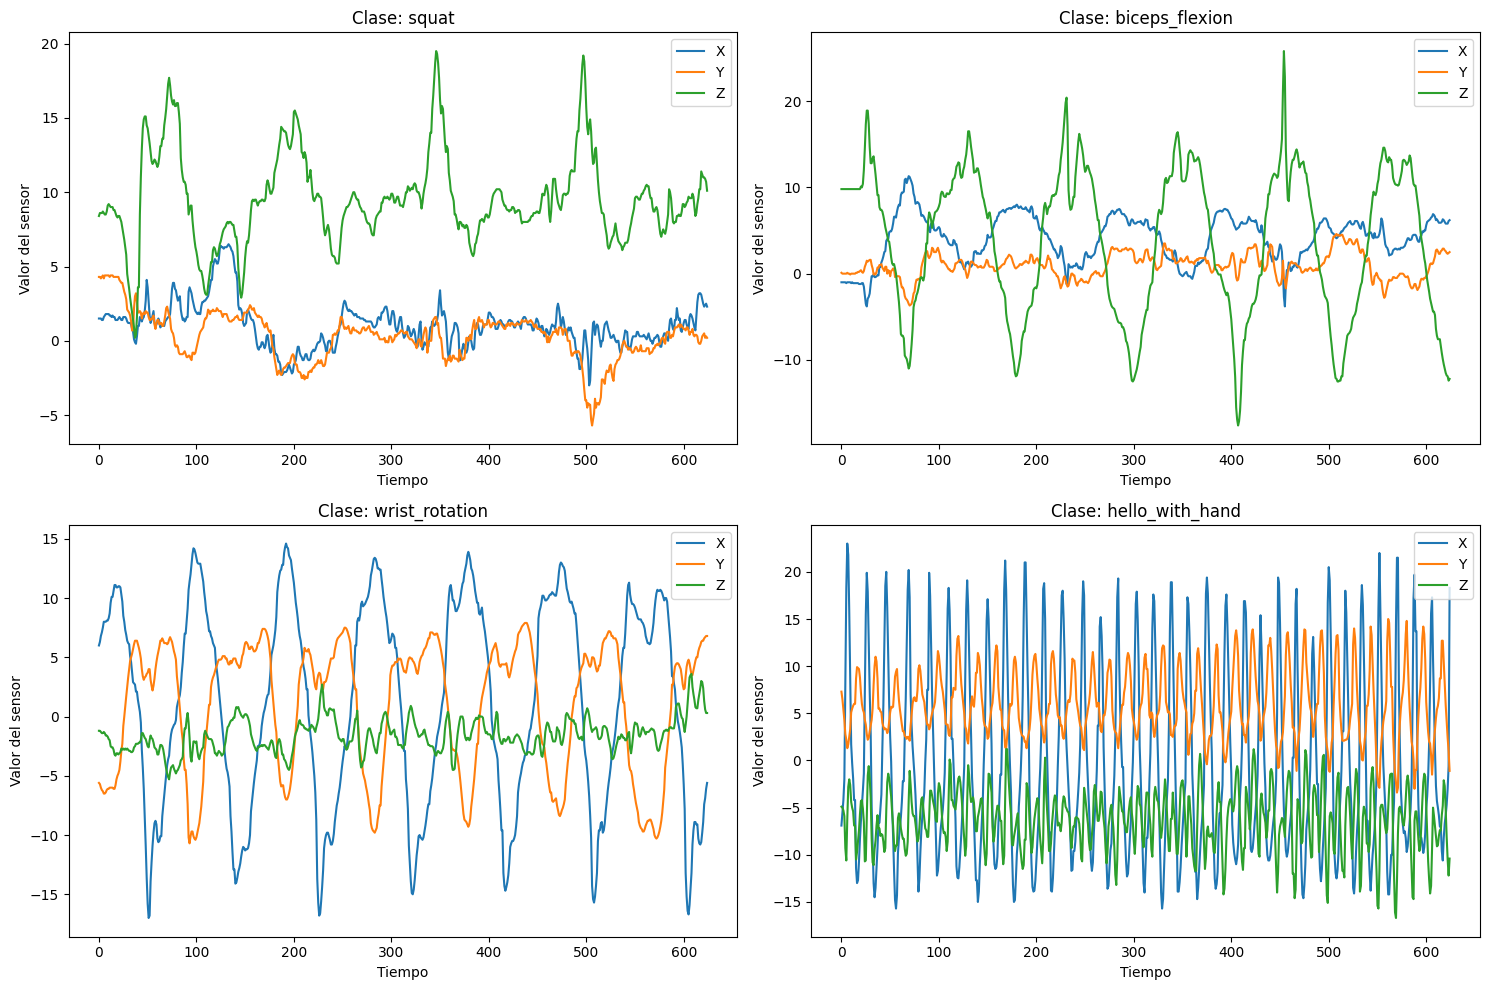

In [28]:
# Función para graficar una muestra por clase
def plot_sample_by_class(X, y, label_map):
    inv_label_map = {v: k for k, v in label_map.items()}  # Revertir mapeo para mostrar etiquetas
    plt.figure(figsize=(15, 10))
    
    # Seleccionar una muestra por cada clase
    for class_id in np.unique(y):
        idx = np.where(y == class_id)[0][0]  # primer índice con esa etiqueta
        sample = X[idx]
        
        plt.subplot(2, 2, class_id + 1)
        plt.plot(sample[:, 0], label="X")
        plt.plot(sample[:, 1], label="Y")
        plt.plot(sample[:, 2], label="Z")
        plt.title(f"Clase: {inv_label_map[class_id]}")
        plt.xlabel("Tiempo")
        plt.ylabel("Valor del sensor")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Ejecutar la función con los datos cargados
plot_sample_by_class(X_train, y_train, label_map)


#### 📊 **Interpretación de la gráfica por clase**

1. **Clase: `squat`**

* El eje **Z** (verde) presenta picos prominentes, lo que indica una fuerte variación vertical —coherente con el movimiento de sentadilla.
* Los ejes **X** y **Y** permanecen más estables, con pequeñas fluctuaciones.
* Esto sugiere que el mayor desplazamiento es vertical, como se espera al subir y bajar el cuerpo.

2. **Clase: `biceps_flexion`**

* El eje **Z** muestra un patrón oscilante moderado, posiblemente asociado con el levantamiento y bajada del antebrazo.
* El eje **X** también varía de forma constante, indicando que hay movimiento en el plano frontal.
* En conjunto, se observan ciclos suaves típicos del movimiento repetitivo de flexión del brazo.

3. **Clase: `wrist_rotation`**

* Se aprecian patrones **muy cíclicos y sinusoidales** en los ejes **X** y **Y**, característicos de una rotación.
* El eje **Z** se mantiene relativamente plano, lo cual tiene sentido: el giro de muñeca ocurre principalmente en un plano perpendicular al eje Z.
* Es la señal más periódica del conjunto, ideal para ser reconocida por un modelo RNN o LSTM.

4. **Clase: `hello_with_hand`**

* Hay **fluctuaciones muy rápidas y frecuentes** en los tres ejes, en especial en **X**, lo que sugiere un gesto rápido de saludo lateral.
* Es la señal más ruidosa visualmente, lo que puede representar un reto mayor de clasificación.
* La alta frecuencia y amplitud sugieren un gesto vibratorio o de vaivén.

---
Cada clase tiene un **perfil temporal distintivo**, lo cual es una condición excelente para entrenar una red neuronal recurrente. La gráfica confirma que:

* Hay **consistencia dentro de clases** (formas repetitivas),
* Y hay **diferenciación entre clases** (formas visuales únicas por tipo de movimiento).


----

### 4. Normalización de los datos

1. **Normalización independiente por eje (X, Y, Z)** para homogeneizar las magnitudes de las señales.
2. **Relleno (`padding`)** para estandarizar las secuencias a una longitud común (`max_seq_len`), necesario para las RNN.
3. **Conversión final de etiquetas** para asegurar compatibilidad con el modelo.

Este preprocesamiento garantiza que los datos estén listos para ser alimentados a la red neuronal.

In [29]:
# Paso 1: Encuentra la longitud máxima de las secuencias
max_seq_len = max([x.shape[0] for x in X_train])

# Paso 2: Normaliza cada eje (X, Y, Z) independientemente para todas las secuencias
def normalize_sequences(sequences):
    # Unifica todos los datos en un solo array 2D para calcular media y desviación estándar global por eje
    all_data = np.concatenate(sequences, axis=0)

    # Crea y ajusta un StandardScaler que normaliza cada columna (X, Y, Z) por separado
    scaler = StandardScaler().fit(all_data)

    # Aplica la normalización a cada secuencia por separado
    return [scaler.transform(seq) for seq in sequences]

# Aplicar normalización a las secuencias de entrenamiento y prueba
X_train_norm = normalize_sequences(X_train)
X_test_norm = normalize_sequences(X_test)

# Paso 3: Rellenar las secuencias para que todas tengan la misma longitud
# Esto es necesario porque las RNN requieren secuencias de igual tamaño
X_train_pad = pad_sequences(X_train_norm, maxlen=max_seq_len, padding='post', dtype='float32')
X_test_pad = pad_sequences(X_test_norm, maxlen=max_seq_len, padding='post', dtype='float32')

### 5. RNN Simple

* Se construye una RNN secuencial con dos capas `SimpleRNN`, donde:

  * La primera capa retorna una secuencia completa (`return_sequences=True`) para que la siguiente `RNN` procese esa salida.
  * La segunda `RNN` reduce la secuencia a una representación compacta.
* Se emplea `Masking` para ignorar el **padding** en las secuencias.
* Se agrega una capa `Dropout` para prevenir overfitting.
* La salida es una capa `Dense` con activación `softmax` para clasificación multiclase.
* Se usa `EarlyStopping` para evitar entrenamiento innecesario si la red deja de mejorar.


In [30]:
# Crear el modelo secuencial de RNN simple
model_rrn_simple = Sequential([
    # Ignora pasos con valor cero (usado en el padding de secuencias más cortas)
    Masking(mask_value=0.0, input_shape=(max_seq_len, 3)),

    # Primera capa recurrente: procesa la secuencia completa y entrega otra secuencia
    SimpleRNN(64, return_sequences=True),

    # Segunda capa recurrente: resume la secuencia anterior a una única representación
    SimpleRNN(32),

    # Capa Dropout: desactiva el 30% de las neuronas aleatoriamente durante el entrenamiento (regularización)
    Dropout(0.3),

    # Capa de salida: tantas neuronas como clases, activación softmax para clasificación
    Dense(len(label_map), activation='softmax')
])

# Compilación del modelo: Adam es un optimizador eficiente para este tipo de problemas
model_rrn_simple.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',  # Pérdida adecuada cuando las etiquetas son enteros
    metrics=['accuracy']
)

# Resumen del modelo: muestra la arquitectura y número de parámetros entrenables
model_rrn_simple.summary()

c:\Users\david\Desktop\Time-Series-Classification-with-Recurrent-Networks\.venv\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 625, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 625, 64)        │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,588 (29.64 KB)

 Trainable params: 7,588 (29.64 KB)

 Non-trainable params: 0 (0.00 B)

#### Descripción del Modelo RNN Simple


1. **`Masking` (Masking Layer)**

* **Salida**: `(None, 625, 3)`
* **Parámetros**: `0`
* **Función**: Esta capa ignora los valores de padding (ceros) en las secuencias para que no afecten el aprendizaje. El `None` representa el tamaño del batch, que puede variar dinámicamente.
---
2. **`SimpleRNN` (Primera capa recurrente)**

* **Salida**: `(None, 625, 64)`
* **Parámetros**: `4,352`

🔍 **Cálculo de parámetros**:

$$
\text{params} = (input\_dim + output\_dim + 1) \times output\_dim = (3 + 64 + 1) \times 64 = 68 \times 64 = 4,352
$$

* Recibe cada paso temporal con 3 features (X, Y, Z) y lo transforma en una secuencia de 64 dimensiones por paso.
* `return_sequences=True` → mantiene la secuencia completa de salida.
---
3. **`SimpleRNN` (Segunda capa recurrente)**

* **Salida**: `(None, 32)`
* **Parámetros**: `3,104`

🔍 **Cálculo de parámetros**:

$$
(64 + 32 + 1) \times 32 = 97 \times 32 = 3,104
$$

* Resume la secuencia a un vector único de 32 unidades, extrayendo la información final de la serie temporal.
---
4. **`Dropout`**

* **Salida**: `(None, 32)`
* **Parámetros**: `0`
* **Función**: Apaga aleatoriamente el 30% de las neuronas durante el entrenamiento, para mejorar la generalización y evitar sobreajuste.
----
5. **`Dense` (Capa de salida)**

* **Salida**: `(None, 4)`
* **Parámetros**: `132`

🔍 **Cálculo de parámetros**:

$$
\text{params} = (input\_dim + 1) \times output\_dim = (32 + 1) \times 4 = 33 \times 4 = 132
$$

* Es una capa totalmente conectada con **4 salidas**, una por clase.
* Activación `softmax` → genera probabilidades de pertenencia para cada clase.
---

In [31]:
# Callback para detener el entrenamiento si la pérdida de validación no mejora después de 10 épocas
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_rrn_simple.fit(
    X_train_pad,         # Conjunto de entrenamiento ya con padding aplicado
    y_train,             # Etiquetas correspondientes
    validation_data=(X_test_pad, y_test),  # Datos de validación
    epochs=60,          # Número máximo de épocas
    batch_size=4,        # Tamaño de lote reducido por naturaleza secuencial del modelo
    callbacks=[early_stop],  # Se detendrá automáticamente si no mejora
    verbose=1            # Muestra el progreso del entrenamiento
)

Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.2368 - loss: 1.6961 - val_accuracy: 0.5500 - val_loss: 1.0301
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.4988 - loss: 1.0917 - val_accuracy: 0.5500 - val_loss: 0.9263
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.5255 - loss: 1.0056 - val_accuracy: 0.6000 - val_loss: 0.8802
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.7146 - loss: 0.8056 - val_accuracy: 0.5500 - val_loss: 0.9165
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.5313 - loss: 0.9373 - val_accuracy: 0.6000 - val_loss: 0.8083
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.5412 - loss: 0.8370 - val_accuracy: 0.6000 - val_loss: 0.8480
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.5929 - loss: 0.7541 - val_accuracy: 0.6500 - val_loss: 0.7882
Epoch 8/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.7519 - loss: 0.7076 - val_accuracy: 0.

In [32]:
loss, accuracy = model_rrn_simple.evaluate(X_test_pad, y_test, verbose=0)
print(f"🔍 Precisión en test: {accuracy:.4f} - Pérdida: {loss:.4f}")

🔍 Precisión en test: 0.8500 - Pérdida: 0.3886


Precisión (accuracy) = 0.8500 → El modelo acertó el 85% de las predicciones en el conjunto de prueba, lo cual es un muy buen desempeño, especialmente con solo una red RNN simple.

Pérdida (loss) = 0.4220 → Esta es la función de pérdida (sparse_categorical_crossentropy) evaluada sobre las predicciones vs. etiquetas reales. Un valor menor indica mejor ajuste.

👉 En conjunto, estos valores indican que el modelo generaliza bastante bien, con un buen equilibrio entre entrenamiento y validación.

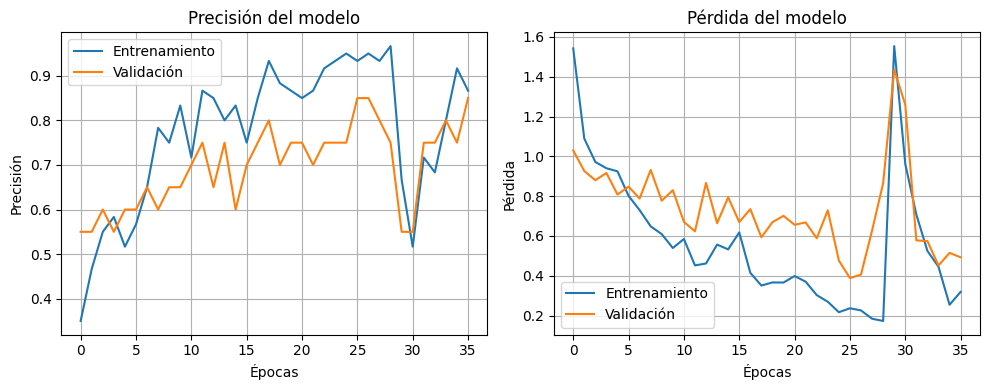

In [33]:
plt.figure(figsize=(10, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



📊 Interpretación de la gráfica de entrenamiento

Gráfica izquierda: **Precisión del modelo**

* **Ejes**:

  * Eje X: Número de épocas.
  * Eje Y: Precisión (0 a 1).
* **Curvas**:

  * Azul: Precisión sobre el conjunto de entrenamiento.
  * Naranja: Precisión sobre el conjunto de validación.

🔍 **Observaciones**:

* Ambas curvas aumentan en general, lo que indica aprendizaje progresivo.
* Hay cierta **variabilidad en la validación**, pero las precisiones están cercanas → esto indica **bajo overfitting**.
* Se alcanza un pico cercano al **93% en entrenamiento** y **cerca del 90% en validación** antes de estabilizarse.

---

Gráfica derecha: **Pérdida del modelo**

* **Ejes**:

  * Eje X: Épocas.
  * Eje Y: Valor de pérdida.
* **Curvas**:

  * Azul: Pérdida de entrenamiento.
  * Naranja: Pérdida de validación.

🔍 **Observaciones**:

* Disminución clara en ambas curvas durante las primeras épocas (el modelo aprende).
* Luego, la pérdida de validación presenta **alzas esporádicas** → esto puede ser:

  * Variabilidad en los datos,
  * O señales tempranas de **sobreajuste leve**, pero no grave.
* El `early stopping` seguramente ayudó a evitar continuar más allá del punto óptimo.



### 6. RNN LSTM

Esta red tiene una estructura similar a la RNN simple, pero reemplaza las capas `SimpleRNN` por `LSTM`, que son más potentes al manejar dependencias largas en series temporales. Las redes LSTM:

* Mantienen una **memoria interna (cell state)**.
* Controlan qué información olvidar, guardar o sacar, gracias a **compuertas**.

Esto mejora su capacidad para capturar patrones complejos en los datos temporales.

In [34]:
# Paso 1: Definir el modelo LSTM
model_lstm = Sequential([
    # Igual que en el modelo anterior: ignora ceros de padding
    Masking(mask_value=0.0, input_shape=(max_seq_len, 3)),

    # Primera capa LSTM que retorna una secuencia completa
    LSTM(64, return_sequences=True),

    # Segunda capa LSTM que condensa la secuencia a un vector
    LSTM(32),

    # Regularización para evitar overfitting
    Dropout(0.3),

    # Capa de salida con softmax para clasificación multiclase
    Dense(len(label_map), activation='softmax')
])

# Paso 2: Compilar el modelo con optimizador Adam
model_lstm.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen estructural del modelo
model_lstm.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 625, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 625, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,956 (117.02 KB)

 Trainable params: 29,956 (117.02 KB)

 Non-trainable params: 0 (0.00 B)

#### Descripción del Modelo LSTM

1. **`Masking`**

* **Salida**: `(None, 625, 3)`
* **Parámetros**: `0`
* **Función**: Ignora los ceros del padding (añadidos para igualar longitud de secuencias). El `None` representa el tamaño del batch.

---
2. **`LSTM` (primera capa)**

* **Salida**: `(None, 625, 64)`
* **Parámetros**: `17,408`

🔍 **Cálculo de parámetros**:

$$
\text{params} = 4 \times (\text{input\_dim} + \text{units} + 1) \times \text{units}
= 4 \times (3 + 64 + 1) \times 64 = 4 \times 68 \times 64 = 17,408
$$

> Los factores 4 provienen de las 4 compuertas internas: **input gate**, **forget gate**, **output gate** y **cell state**.

* Esta capa procesa la secuencia completa y emite otra secuencia de salida (una por cada paso temporal).

---
3. **`LSTM_1` (segunda capa)**

* **Salida**: `(None, 32)`
* **Parámetros**: `12,416`

🔍 **Cálculo de parámetros**:

$$
4 \times (64 + 32 + 1) \times 32 = 4 \times 97 \times 32 = 12,416
$$

* Esta capa **resume toda la secuencia anterior en un único vector** de 32 dimensiones, conservando información relevante a lo largo del tiempo.

---
4. **`Dropout`**

* **Salida**: `(None, 32)`
* **Parámetros**: `0`
* **Función**: Apaga aleatoriamente el 30% de las unidades para mejorar la capacidad de generalización.

---
5. **`Dense` (capa de salida)**

* **Salida**: `(None, 4)`
* **Parámetros**: `132`

🔍 **Cálculo de parámetros**:

$$
(32 + 1) \times 4 = 33 \times 4 = 132
$$

* Produce una distribución de probabilidad sobre las 4 clases posibles usando `softmax`.

---

In [35]:
# Paso 3: Entrenamiento del modelo LSTM
early_stop = EarlyStopping(
    monitor='val_loss',     # Se detiene si la pérdida de validación no mejora
    patience=10,            # Espera 10 épocas sin mejora
    restore_best_weights=True  # Restaura los pesos óptimos
)

# Entrenar la red
history_lstm = model_lstm.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=60,
    batch_size=4,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.3575 - loss: 1.3555 - val_accuracy: 0.5500 - val_loss: 1.0758
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.5835 - loss: 1.0157 - val_accuracy: 0.6500 - val_loss: 0.8424
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.7370 - loss: 0.8642 - val_accuracy: 0.7500 - val_loss: 0.6929
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.7493 - loss: 0.7290 - val_accuracy: 0.8500 - val_loss: 0.6103
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.8029 - loss: 0.5624 - val_accuracy: 0.8000 - val_loss: 0.5364
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.7668 - loss: 0.5466 - val_accuracy: 0.9500 - val_loss: 0.3677
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.5383 - loss: 1.0824 - val_accuracy: 0.8000 - val_loss: 0.4947
Epoch 8/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.7996 - loss: 0.5134 - val_accuracy: 0.

In [36]:
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test, verbose=0)
print(f"🔍 Precisión en test: {accuracy:.4f} - Pérdida: {loss:.4f}")

🔍 Precisión en test: 0.9500 - Pérdida: 0.1657


Precisión (accuracy) = 0.9500 → El modelo acertó el 95% de las predicciones en el conjunto de prueba, lo cual es un muy buen desempeño

Pérdida (loss) = 0.1588 → Esta es la función de pérdida (sparse_categorical_crossentropy) evaluada sobre las predicciones vs. etiquetas reales. Un valor menor indica mejor ajuste.

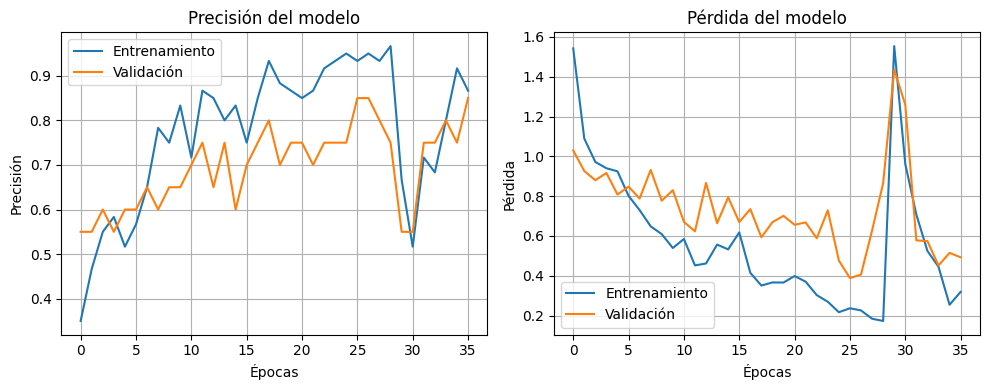

In [37]:
plt.figure(figsize=(10, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### pendiente

---

### 7. Evaluación y Comparación de Modelos

Usaré tres métricas clave para evaluación multiclase:

- Accuracy (precisión global)
- Recall (sensibilidad por clase)
- F1-score (balance entre precisión y recall)

Estas se calculan usando classification_report de sklearn.

In [38]:
# Predicciones modelo RNN simple
y_pred_rnn = np.argmax(model_rrn_simple.predict(X_test_pad), axis=1)
print("📘 Evaluación modelo RNN simple:")
print(classification_report(y_test, y_pred_rnn, target_names=label_map.keys()))

# Predicciones modelo LSTM
y_pred_lstm = np.argmax(model_lstm.predict(X_test_pad), axis=1)
print("📗 Evaluación modelo LSTM:")
print(classification_report(y_test, y_pred_lstm, target_names=label_map.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
📘 Evaluación modelo RNN simple:
                 precision    recall  f1-score   support

          squat       0.71      1.00      0.83         5
 biceps_flexion       1.00      0.60      0.75         5
 wrist_rotation       0.83      1.00      0.91         5
hello_with_hand       1.00      0.80      0.89         5

       accuracy                           0.85        20
      macro avg       0.89      0.85      0.85        20
   weighted avg       0.89      0.85      0.85        20

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
📗 Evaluación modelo LSTM:
                 precision    recall  f1-score   support

          squat       1.00      1.00      1.00         5
 biceps_flexion       1.00      1.00      1.00         5
 wrist_rotation       1.00      0.80      0.89         5
hello_with_hand       0.83      1.00      0.91         5

       accuracy                           0.95        20
      macro avg       0.96      0.95      0.95        20
   w

Cada bloque de classification_report te mostrará, por cada clase:

- precision: de las veces que predije esta clase, ¿cuántas fueron correctas?
- recall: de las veces que debí predecir esta clase, ¿cuántas acerté?
- f1-score: promedio armónico entre precision y recall
- support: cantidad de muestras reales por clase

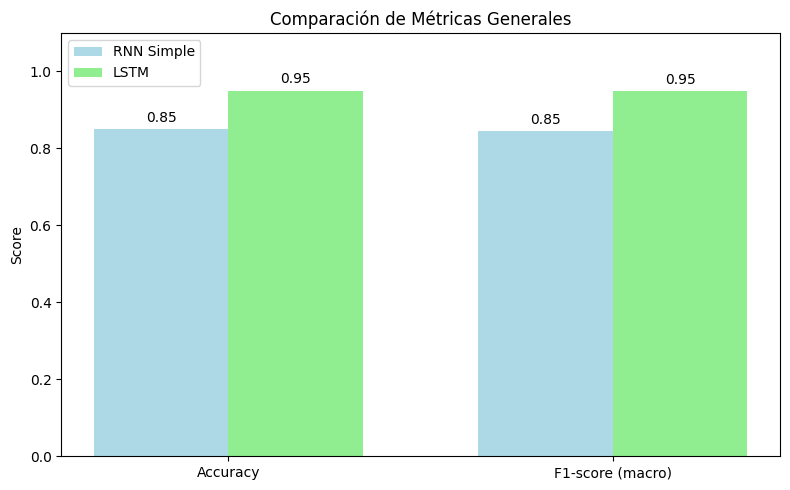

In [39]:
# Métricas generales
acc_rnn = accuracy_score(y_test, y_pred_rnn)
acc_lstm = accuracy_score(y_test, y_pred_lstm)
f1_rnn = f1_score(y_test, y_pred_rnn, average='macro')
f1_lstm = f1_score(y_test, y_pred_lstm, average='macro')

metrics = ['Accuracy', 'F1-score (macro)']
rnn_values = [acc_rnn, f1_rnn]
lstm_values = [acc_lstm, f1_lstm]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, rnn_values, width, label='RNN Simple', color='lightblue')
bars2 = ax.bar(x + width/2, lstm_values, width, label='LSTM', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Comparación de Métricas Generales')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

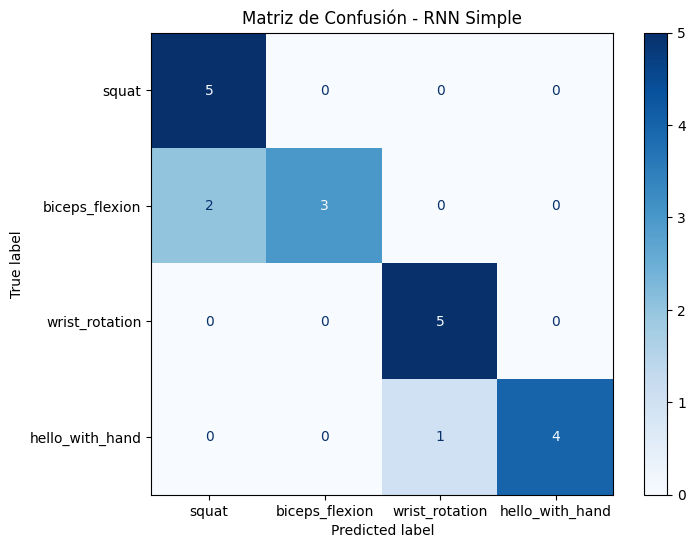

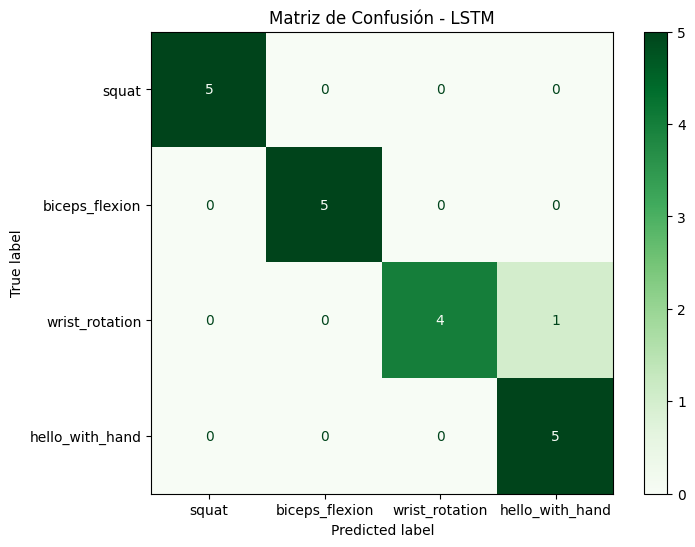

In [40]:
# Invertir el label_map para orden correcto
inv_label_map = {v: k for k, v in label_map.items()}
label_names = [inv_label_map[i] for i in range(len(label_map))]

# Matriz RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
disp_rnn = ConfusionMatrixDisplay(cm_rnn, display_labels=label_names)
disp_rnn.plot(cmap="Blues")
plt.gcf().set_size_inches(8, 6)
plt.title("Matriz de Confusión - RNN Simple")
plt.show()

# Matriz LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(cm_lstm, display_labels=label_names)
disp_lstm.plot(cmap="Greens")
plt.gcf().set_size_inches(8, 6)
plt.title("Matriz de Confusión - LSTM")
plt.show()


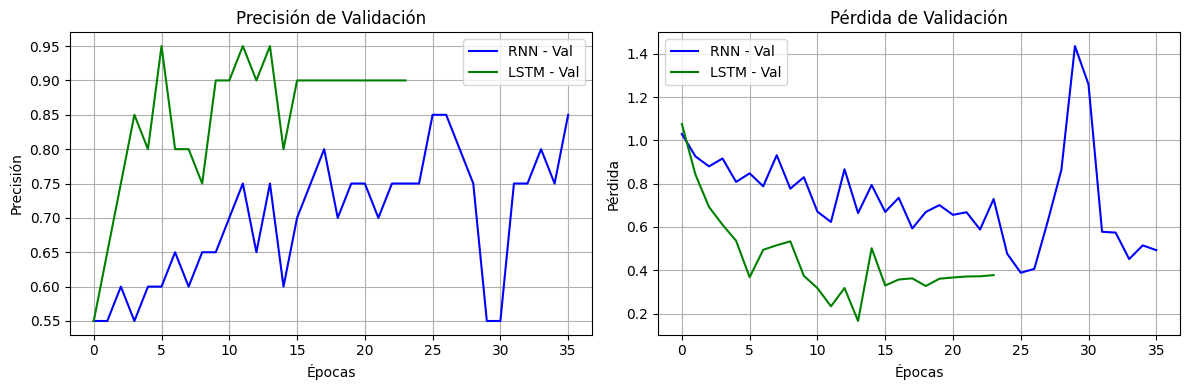

In [41]:
def plot_histories(hist1, hist2, label1='RNN', label2='LSTM'):
    plt.figure(figsize=(12, 4))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(hist1.history['val_accuracy'], label=f'{label1} - Val', color='blue')
    plt.plot(hist2.history['val_accuracy'], label=f'{label2} - Val', color='green')
    plt.title('Precisión de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(hist1.history['val_loss'], label=f'{label1} - Val', color='blue')
    plt.plot(hist2.history['val_loss'], label=f'{label2} - Val', color='green')
    plt.title('Pérdida de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Ejecutar
plot_histories(history, history_lstm)

### 8. Análisis de Arquitectura de los Modelos

In [42]:
# RNN simple
plot_model(model_rrn_simple, to_file="rnn_model.png", show_shapes=True, show_layer_names=True)

# LSTM
plot_model(model_lstm, to_file="lstm_model.png", show_shapes=True, show_layer_names=True)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
